## Лабораторная работа 4
### Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

%matplotlib inline

In [5]:
def draw(x, y, xl=None, yl=None, label=None):
    plt.plot(x, y, label=label)
    if label is not None:
        plt.legend()
    plt.xlabel(xl, size=14)
    plt.ylabel(yl, size=14)
    plt.title('Thermal conduction')
    return plt

#### Explicit Finite Difference Schemes

In [161]:
def solve_explicit(a, b, k, f, g1, g2, phi, T, h, dt, method=2):
    """Solve heat conduction equation using the explicit finite difference schemes.
    
    ---Parametres---
    method - int:
        1 -> accuracy of boundary condition is O(h)
        2 -> accuracy of boundary condition is O(h^2)
    """
    nt = int(T/dt) + 1
    nx = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, nx)
    t_vec = np.linspace(0, T, nt)
    A = np.zeros((nt, nx))
    A[0, ] = [phi(x) for x in x_vec]
    A[:, 0] = [g1(t) for t in t_vec]
    
    if method == 1:
        for i in range(nt - 1):
            for j in range(1, nx - 1):            
                A[i + 1, j] = (k*dt/h**2*A[i, j-1] + (1-2*k*dt/h**2)*A[i, j] 
                               + k*dt/h**2*A[i, j+1] + dt*f(x_vec[j], t_vec[i]))
            A[i + 1, -1] = A[i + 1, -2] + h*g2(t_vec[i + 1])
    else:
        for i in range(nt - 1):
            for j in range(1, nx - 1):            
                A[i + 1, j] = (k*dt/h**2*A[i, j-1] + (1-2*k*dt/h**2)*A[i, j] 
                               + k*dt/h**2*A[i, j+1] + dt*f(x_vec[j], t_vec[i]))
            A[i + 1, -1] = A[i, -1] + 2*k*dt*(A[i, -2] + h*g2(t_vec[i]) - A[i, -1])/h**2 + dt*f(b, t_vec[i])
    return x_vec, t_vec, A

In [30]:
a, b = -1, 1
k = 0.5
h = (b-a) / 9
dt = 0.5*h**2/(4*k) # dt<=0.5*h**2/k -- stability condition
T = 0.4
x_r, t_r, A = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, 2)

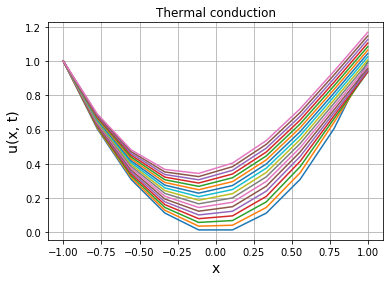

In [31]:
for i in range(0, int(T/dt)+1, 2):
    draw(x_r, A[i], 'x', 'u(x, t)') #, fr't={i}$\tau$')
plt.grid()
plt.show()

#### Implicit Finite Difference Schemes

In [162]:
def solve_implicit(a, b, k, f, g1, g2, phi, T, h, dt):
    """Solve heat conduction equation using the implicit finite difference schemes
    with accuracy of boundary condition: O(h).
    """
    nt = int(T/dt) + 1
    nx = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, nx)
    t_vec = np.linspace(0, T, nt)
    U = np.zeros((nt, nx))
    U[0] = [phi(x) for x in x_vec]
    U[:, 0] = [g1(t) for t in t_vec]
    
    A = np.zeros((nx, nx))
    for i in range(1, nx - 1):   
        A[i, i-1] = -k*dt/h**2
        A[i, i] = 1 + 2*dt*k/h**2
        A[i, i+1] = -k*dt/h**2
        
    A[0, 0] = 1
    A[-1, -2] = -1
    A[-1, -1] = 1
    for i in range(1, nt):
        b = np.array([dt*f(x, t_vec[i]) for x in x_vec]) + U[i - 1]
        b[0] = g1(t_vec[i])
        b[-1] = h*g2(t_vec[i])
        U[i] = np.linalg.solve(A, b)
    return x_vec, t_vec, U

In [163]:
def solve_implicit2(a, b, k, f, g1, g2, phi, T, h, dt):
    """Solve heat conduction equation using the implicit finite difference schemes
    with accuracy of boundary condition: O(h^2).
    """
    nt = int(T/dt) + 1
    nx = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, nx)
    t_vec = np.linspace(0, T, nt)
    U = np.zeros((nt, nx))
    U[0] = [phi(x) for x in x_vec]
    U[:, 0] = [g1(t) for t in t_vec]
    
    A = np.zeros((nx+1, nx+1))
    for i in range(1, nx):   
        A[i, i-1] = -k*dt/h**2
        A[i, i] = 1 + 2*dt*k/h**2
        A[i, i+1] = -k*dt/h**2
    A[0, 0] = 1  
    A[-1, -1] = 1
    A[-1, -3] = -1
    for i in range(1, nt):
        b = np.zeros(nx+1)
        b[1:-1] = [dt*f(x, t_vec[i]) for x in x_vec[1:]] + U[i - 1, 1:]
        b[0] = g1(t_vec[i])
        b[-1] = 2*h*g2(t_vec[i])
        U[i] = np.linalg.solve(A, b)[:-1]
    return x_vec, t_vec, U

Method 1. O(h)

In [11]:
a, b = -1, 1
k = 0.5
h = (b-a) / 9
dt = h**2/4 # dt<=0.5*h**2/k -- stability condition
T = 0.4
x_r, t_r, U = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)

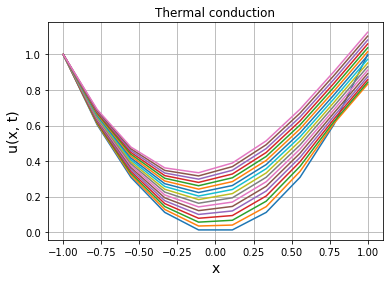

In [13]:
for i in range(0, int(T/dt)+1, 2):
    draw(x_r, U[i], 'x', 'u(x, t)')
plt.grid()
plt.show()

Method 2. O(h^2)

In [14]:
a, b = -1, 1
k = 0.5
h = (b-a) / 9
dt = h**2/4 # dt<=0.5*h**2/k -- stability condition
T = 0.4
x_r, t_r, U = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)

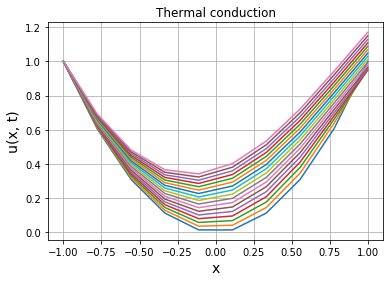

In [15]:
for i in range(0, int(T/dt)+1, 2):
    draw(x_r, U[i], 'x', 'u(x, t)')
plt.grid()
plt.show()

#### Computations

Fixed _h_

In [166]:
def std(h, dt, ind, method, way):
    if method == 1:
        _, _, A = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
        dt /= 2
        _, _, B = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
    else:
        if way == 1:
            _, _, A = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            dt /= 2
            _, _, B = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
        else:
            _, _, A = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            dt /= 2
            _, _, B = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
    return (A[ind] - B[2*ind]).std()


def mxa(h, dt, ind, method, way):
    if method == 1:
        _, _, A = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
        dt /= 2
        _, _, B = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
    else:
        if way == 1:
            _, _, A = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            dt /= 2
            _, _, B = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
        else:
            _, _, A = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            dt /= 2
            _, _, B = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
    return max(abs(A[ind] - B[2*ind]))


def print_stat(t1, t2, n, h, dt, method, way):
    """Print a table describing scheme and method with fixed h.
    
    method - int:
        1 --> explicit scheme
        2 --> implicit scheme
    way - int:
        1 --> accuracy of boundary condition is O(h)
        2 --> accuracy of boundary condition is O(h^2)
    """
    table = PrettyTable()
    table.field_names = ['h', 'tau', 'std(t=t1)', 'std(t=t2)', 'mxa(t=t1)', 'mxa(t=t2)']
    for i in range(n):
        ind1 = int(t1/dt)
        ind2 = int(t2/dt)
        std1 = std(h, dt, ind1, method, way)
        std2 = std(h, dt, ind2, method, way)
        mxa1 = mxa(h, dt, ind1, method, way)
        mxa2 = mxa(h, dt, ind2, method, way)
        dt /= 2
        table.add_row([h, dt, f'{std1:.5e}', f'{std2:.5e}', f'{mxa1:.5e}', f'{mxa2:.5e}'])
    print(table)

In [157]:
a, b = -1, 1
k = 0.5
T = 0.4
h = 0.1
t1 = 0.05
t2 = 0.25
dt = 0.01

In [120]:
print('Explicit sceme')
print(' Method 1')
print_stat(t1, t2, 5, h, dt, 1, 1)
print(' Method 2')
print_stat(t1, t2, 5, h, dt, 1, 2)

Explicit sceme
 Method 1
+-----+-----------+-------------+-------------+-------------+-------------+
|  h  |    tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+-----+-----------+-------------+-------------+-------------+-------------+
| 0.1 |   0.005   | 2.44816e-03 | 1.24472e-03 | 6.93174e-03 | 3.24985e-03 |
| 0.1 |   0.0025  | 1.14582e-03 | 6.13270e-04 | 3.16482e-03 | 1.59929e-03 |
| 0.1 |  0.00125  | 5.65366e-04 | 3.05452e-04 | 1.56498e-03 | 7.97890e-04 |
| 0.1 |  0.000625 | 2.80854e-04 | 1.52433e-04 | 7.78197e-04 | 3.98508e-04 |
| 0.1 | 0.0003125 | 1.39976e-04 | 7.61436e-05 | 3.88033e-04 | 1.99145e-04 |
+-----+-----------+-------------+-------------+-------------+-------------+
 Method 2
+-----+-----------+-------------+-------------+-------------+-------------+
|  h  |    tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+-----+-----------+-------------+-------------+-------------+-------------+
| 0.1 |   0.005   | 3.29170e-03 | 1.98142e-03 | 1.101

In [121]:
print('Implicit scheme')
print(' Method 1')
print_stat(t1, t2, 5, h, dt, 2, 1)
print(' Method 2')
print_stat(t1, t2, 5, h, dt, 2, 2)

Implicit scheme
 Method 1
+-----+-----------+-------------+-------------+-------------+-------------+
|  h  |    tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+-----+-----------+-------------+-------------+-------------+-------------+
| 0.1 |   0.005   | 5.53910e-04 | 2.70193e-04 | 1.55583e-03 | 5.14543e-04 |
| 0.1 |   0.0025  | 2.87205e-04 | 1.35984e-04 | 7.97280e-04 | 2.59389e-04 |
| 0.1 |  0.00125  | 1.46196e-04 | 6.82152e-05 | 4.02958e-04 | 1.30206e-04 |
| 0.1 |  0.000625 | 7.37495e-05 | 3.41636e-05 | 2.02483e-04 | 6.52285e-05 |
| 0.1 | 0.0003125 | 3.70381e-05 | 1.70958e-05 | 1.01483e-04 | 3.26453e-05 |
+-----+-----------+-------------+-------------+-------------+-------------+
 Method 2
+-----+-----------+-------------+-------------+-------------+-------------+
|  h  |    tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+-----+-----------+-------------+-------------+-------------+-------------+
| 0.1 |   0.005   | 6.34893e-04 | 3.02378e-04 | 2.24

Fixed $\tau$

In [165]:
def stdh(h, dt, ind, method, way):
    if method == 1:
        _, _, A = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
        h /= 2
        _, _, B = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
    else:
        if way == 1:
            _, _, A = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            h /= 2
            _, _, B = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
        else:
            _, _, A = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            h /= 2
            _, _, B = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
    return (A[:, ind] - B[:, 2*ind]).std()


def mxah(h, dt, ind, method, way):
    if method == 1:
        _, _, A = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
        h /= 2
        _, _, B = solve_explicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt, way)
    else:
        if way == 1:
            _, _, A = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            h /= 2
            _, _, B = solve_implicit(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
        else:
            _, _, A = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
            h /= 2
            _, _, B = solve_implicit2(a, b, k, lambda x,t: x, lambda x: 1, lambda x: 1, lambda x: x**2, T, h, dt)
    return max(abs(A[:, ind] - B[:, 2*ind]))


def print_stath(x1, x2, n, h, dt, method, way):
    """Print a table describing scheme and method with fixed tau.
    
    method - int:
        1 --> explicit scheme
        2 --> implicit scheme
    way - int:
        1 --> accuracy of boundary condition is O(h)
        2 --> accuracy of boundary condition is O(h^2)
    """
    table = PrettyTable()
    table.field_names = ['h', 'tau', 'std(t=t1)', 'std(t=t2)', 'mxa(t=t1)', 'mxa(t=t2)']
    for i in range(n):
        ind1 = int(x1/h)
        ind2 = int(x2/h)
        std1 = stdh(h, dt, ind1, method, way)
        std2 = stdh(h, dt, ind2, method, way)
        mxa1 = mxah(h, dt, ind1, method, way)
        mxa2 = mxah(h, dt, ind2, method, way)
        h /= 2
        table.add_row([h, f'{dt:.2e}', f'{std1:.5e}', f'{std2:.5e}', f'{mxa1:.5e}', f'{mxa2:.5e}'])
    print(table)

In [155]:
a, b = -1, 1
k = 0.5
T = 0.00008
h = 0.1
x1 = 0.05
x2 = 0.25
dt = 0.0000005

In [156]:
print('Explicit scheme')
print(' Method1')
print_stath(x1, x2, 5, h, dt, 1, 1)
print(' Method2')
print_stath(x1, x2, 5, h, dt, 1, 2)

Explicit scheme
 Method1
+----------+----------+-------------+-------------+-------------+-------------+
|    h     |   tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+----------+----------+-------------+-------------+-------------+-------------+
|   0.05   | 5.00e-07 | 0.00000e+00 | 3.81061e-15 | 0.00000e+00 | 1.07692e-14 |
|  0.025   | 5.00e-07 | 3.46925e-15 | 1.43986e-15 | 9.32587e-15 | 3.88578e-15 |
|  0.0125  | 5.00e-07 | 1.54781e-15 | 1.44241e-15 | 5.77316e-15 | 5.55112e-15 |
| 0.00625  | 5.00e-07 | 2.43308e-15 | 7.47029e-16 | 8.65974e-15 | 2.99760e-15 |
| 0.003125 | 5.00e-07 | 2.58621e-16 | 7.15740e-16 | 6.66134e-16 | 2.33147e-15 |
+----------+----------+-------------+-------------+-------------+-------------+
 Method2
+----------+----------+-------------+-------------+-------------+-------------+
|    h     |   tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+----------+----------+-------------+-------------+-------------+-------------+
|   0.

In [127]:
print('Implicit scheme')
print(' Method1')
print_stath(x1, x2, 5, h, dt, 2, 1)
print(' Method2')
print_stath(x1, x2, 5, h, dt, 2, 2)

Implicit scheme
 Method1
+----------+----------+-------------+-------------+-------------+-------------+
|    h     |   tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+----------+----------+-------------+-------------+-------------+-------------+
|   0.05   | 5.00e-07 | 0.00000e+00 | 3.46924e-15 | 0.00000e+00 | 1.08802e-14 |
|  0.025   | 5.00e-07 | 3.28650e-15 | 1.15086e-15 | 7.54952e-15 | 3.88578e-15 |
|  0.0125  | 5.00e-07 | 2.74511e-15 | 1.13687e-15 | 9.65894e-15 | 4.10783e-15 |
| 0.00625  | 5.00e-07 | 3.00254e-15 | 2.66992e-15 | 1.04361e-14 | 9.21485e-15 |
| 0.003125 | 5.00e-07 | 5.98401e-15 | 4.47801e-15 | 2.04281e-14 | 1.52101e-14 |
+----------+----------+-------------+-------------+-------------+-------------+
 Method2
+----------+----------+-------------+-------------+-------------+-------------+
|    h     |   tau    |  std(t=t1)  |  std(t=t2)  |  mxa(t=t1)  |  mxa(t=t2)  |
+----------+----------+-------------+-------------+-------------+-------------+
|   0.